# Exafluence Hackathon

A business loan is an unsecured form of credit intended to cover various expenses in a business. Borrowers need not mortgage any asset to avail funds. Self-employed non-professionals, and self-employed professionals can apply for a business loan. As soon as they achieve the mandatory eligibility criteria, they can apply online for business loan applications to get funds. Some of the companies go out of business after taking the business loan and tend to default. Data is collected from various banks.

The dataset contains an exhaustive list of businesses who have taken business loans from various banks over the years. 

The goal is to predict whether a business loan applicant will default or not.

### Import necessary libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sweetviz
import missingno as msno

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn import metrics
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

### Import the dataset

In [2]:
train_df = pd.read_csv('Train_Set_90621.csv', parse_dates = ['Approved_Timestamp'])
test_df = pd.read_csv('Test_Set_90621.csv', parse_dates = ['Approved_Timestamp'])
test_appID = test_df['Application ID']
train_df['origin'] = 'Train'
test_df['origin'] = 'Test'
df = pd.concat([train_df, test_df])
df.sample(10)

,Application ID,Bank Masked,Bank Type,Approved_Timestamp,Name Masked,Business Owner State,Business_Industry_Type_Code,Approved_Year,New Business,Term,...,Company Branch Code,City or Rural,Jobs Generated,Carry-forward Credit,Documents Provided,Balance Left,Amount Defaulted,Final_Appved_Amount,Default_Status,origin
92934,1020292935,Bank_Number_13,Govt,2012-06-11,Business_Name_14618,Haryana,622840,2012,2.0,84,...,0,1,2,Y,N,0,0,1225000,0.0,Train
155145,1020355146,Bank_Name_200,Govt,2002-08-10,Business_Name_129729,Haryana,1231,2002,2.0,120,...,1,0,0,N,N,0,0,5600000,0.0,Train
138462,1020338463,Bank_Name_196,Private,2013-06-29,Business_Name_38131,Haryana,542601,2013,1.0,60,...,1,1,0,N,Y,0,0,2975000,0.0,Train
25576,20210625577,Bank_Name_42,Private,2002-05-04,Business_Name_1330,Haryana,812342,2002,1.0,84,...,1,1,1,N,N,0,0,1750000,NaN,Test
97817,1020297818,Bank_Name_5625,Private,2008-06-29,Business_Name_139556,Haryana,239561,2008,1.0,48,...,0,1,0,N,N,0,0,6300000,0.0,Train
29913,20210629914,Bank_Name_39890,Private,2015-06-04,Business_Name_173821,Uttar Pradesh,455229,2015,2.0,120,...,1,1,0,N,Y,0,0,4200000,NaN,Test
195111,1020395112,Bank_Name_42,Private,2001-10-09,Business_Name_42384,Haryana,723341,2001,1.0,84,...,1,1,0,Y,N,0,0,350000,0.0,Train
138712,1020338713,Bank_Number_13,Govt,2011-10-07,Business_Name_85746,Haryana,542340,2011,1.0,120,...,1,1,0,N,N,0,0,24675000,1.0,Train
57188,1020257189,Bank_Name_42,Private,2002-03-25,Business_Name_30078,Maharashtra,449541,2002,1.0,36,...,1,0,0,Y,N,0,0,1050000,0.0,Train
15826,20210615827,Bank_Name_231,Govt,2006-03-05,Business_Name_70416,Uttar Pradesh,1231,2006,1.0,84,...,1,1,1,N,N,0,0,4760000,NaN,Test


In [3]:
df.columns = df.columns.str.replace(" ", "_")

In [4]:
df.drop('Application_ID', axis = 1, inplace = True)

### Basic EDA

In [5]:
def basic_eda(df):
    print('SHAPE')
    print(df.shape)
    print('.' * 100)
    print('\nINFO')
    print(df.info())
    print('.' * 100)
    print('\nMISSING VALUES')
    print('Total Missing:', df.isna().sum().sum())
    print(df.isna().sum().sort_values(ascending = False))
    print('.' * 100)
    print('\nDUPLICATES')
    print(df.duplicated().sum())
    print('.' * 100)  
    print('\nDESCRIBE')
    print(df.describe())
    

In [6]:
basic_eda(df)

SHAPE
(278741, 29)
....................................................................................................

INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 278741 entries, 0 to 83622
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Bank_Masked                     278613 non-null  object        
 1   Bank_Type                       278613 non-null  object        
 2   Approved_Timestamp              278141 non-null  datetime64[ns]
 3   Name_Masked                     278740 non-null  object        
 4   Business_Owner_State            278738 non-null  object        
 5   Business_Industry_Type_Code     278741 non-null  int64         
 6   Approved_Year                   278741 non-null  int64         
 7   New_Business                    278690 non-null  float64       
 8   Term                            278741 non-null  int64         
 9   

In [7]:
print('Unique values in the dataset:\n')

for i in df.columns:
    print('_' * 50)
    print(i + ':', df[i].nunique(), df[i].dtype)
    print(df[i].value_counts())

Unique values in the dataset:

__________________________________________________
Bank_Masked: 58337 object
Bank_Name_42       13000
Bank_Name_3         9551
Bank_Number_13      8748
Bank_Name_11        7073
Bank_Number_37      6332
                   ...  
Bank_Name_35548        1
Bank_Name_31048        1
Bank_Name_54057        1
Bank_Name_14205        1
Bank_Name_25724        1
Name: Bank_Masked, Length: 58337, dtype: int64
__________________________________________________
Bank_Type: 2 object
Private    185976
Govt        92637
Name: Bank_Type, dtype: int64
__________________________________________________
Approved_Timestamp: 6463 datetime64[ns]
2009-07-13    310
2011-09-15    226
2011-05-31    214
2011-09-16    207
2011-10-09    200
             ... 
2000-01-15      1
2000-04-17      1
2000-04-28      1
2000-02-13      1
2000-02-17      1
Name: Approved_Timestamp, Length: 6463, dtype: int64
__________________________________________________
Name_Masked: 188824 object
Business_Name

Default_Status: 2 float64
0.0    159880
1.0     35238
Name: Default_Status, dtype: int64
__________________________________________________
origin: 2 object
Train    195118
Test      83623
Name: origin, dtype: int64


In [8]:
default = df[df['Default_Status'] == 1]

print('Unique values in the dataset:\n')

for i in default.columns:
    print('_' * 50)
    print(i + ':', default[i].nunique(), default[i].dtype)
    print(default[i].value_counts())

Unique values in the dataset:

__________________________________________________
Bank_Masked: 9824 object
Bank_Name_42        1533
Bank_Number_13      1207
Bank_Name_3         1180
Bank_Name_11         863
Bank_Number_37       837
                    ... 
Bank_Number_1251       1
Bank_Name_50624        1
Bank_Name_45659        1
Bank_Name_54472        1
Bank_Name_13354        1
Name: Bank_Masked, Length: 9824, dtype: int64
__________________________________________________
Bank_Type: 2 object
Private    23237
Govt       11988
Name: Bank_Type, dtype: int64
__________________________________________________
Approved_Timestamp: 5742 datetime64[ns]
2009-07-13    40
2011-05-31    38
2011-09-16    34
2011-08-05    34
2011-10-10    32
              ..
2016-09-22     1
2016-08-14     1
2001-08-22     1
2014-03-06     1
2014-12-14     1
Name: Approved_Timestamp, Length: 5742, dtype: int64
__________________________________________________
Name_Masked: 33593 object
Business_Name_39        12
Bu

In [9]:
df.isna().sum().sort_values(ascending = False)

Default_Status                    83623
Carry-forward_Credit               1390
Documents_Provided                  799
Approved_Timestamp                  600
BankState                           129
Bank_Masked                         128
Bank_Type                           128
New_Business                         51
Business_Owner_State                  3
Expected_Company_Income               3
Name_Masked                           1
Employees                             0
Business_Industry_Type_Code           0
Approved_Year                         0
Term                                  0
Interest_Rate                         0
origin                                0
Gross_Disbursed_Amount                0
Term_years                            0
Male_to_Female_Employees_Ratio        0
Funds_available_with_company          0
Gross_Apprv_Amount                    0
Company_Branch_Code                   0
City_or_Rural                         0
Jobs_Generated                        0


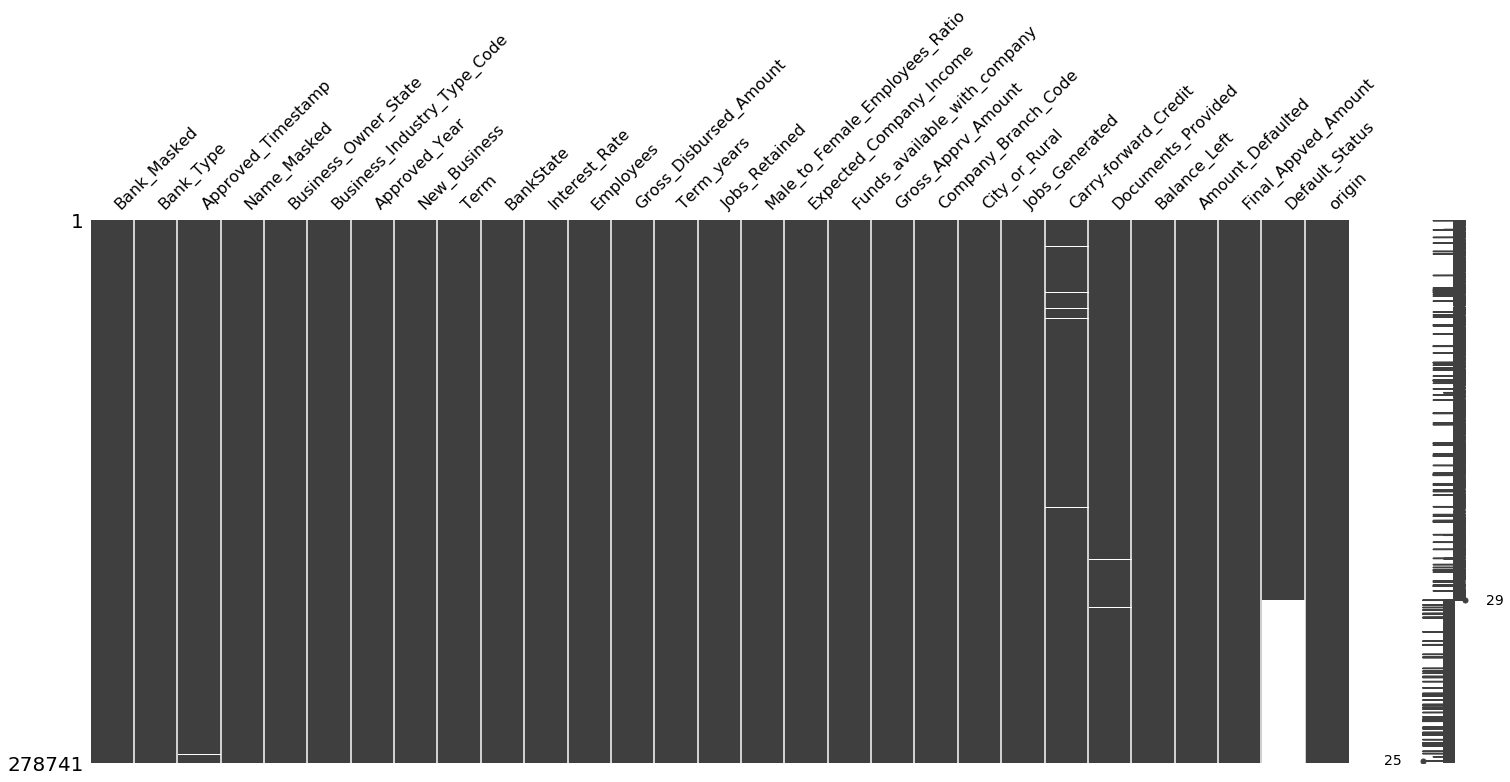

In [10]:
msno.matrix(df)

#### Visualization / Visual EDA

In [11]:
# my_report = sweetviz.compare([train_df, "Train"], [test_df, "Test"], "Default_Status")
# my_report.show_html("Report.html")

In [12]:
df_num = df.select_dtypes(include = 'number', exclude = 'datetime')
df_cat = df.select_dtypes(exclude = 'number' and 'datetime')

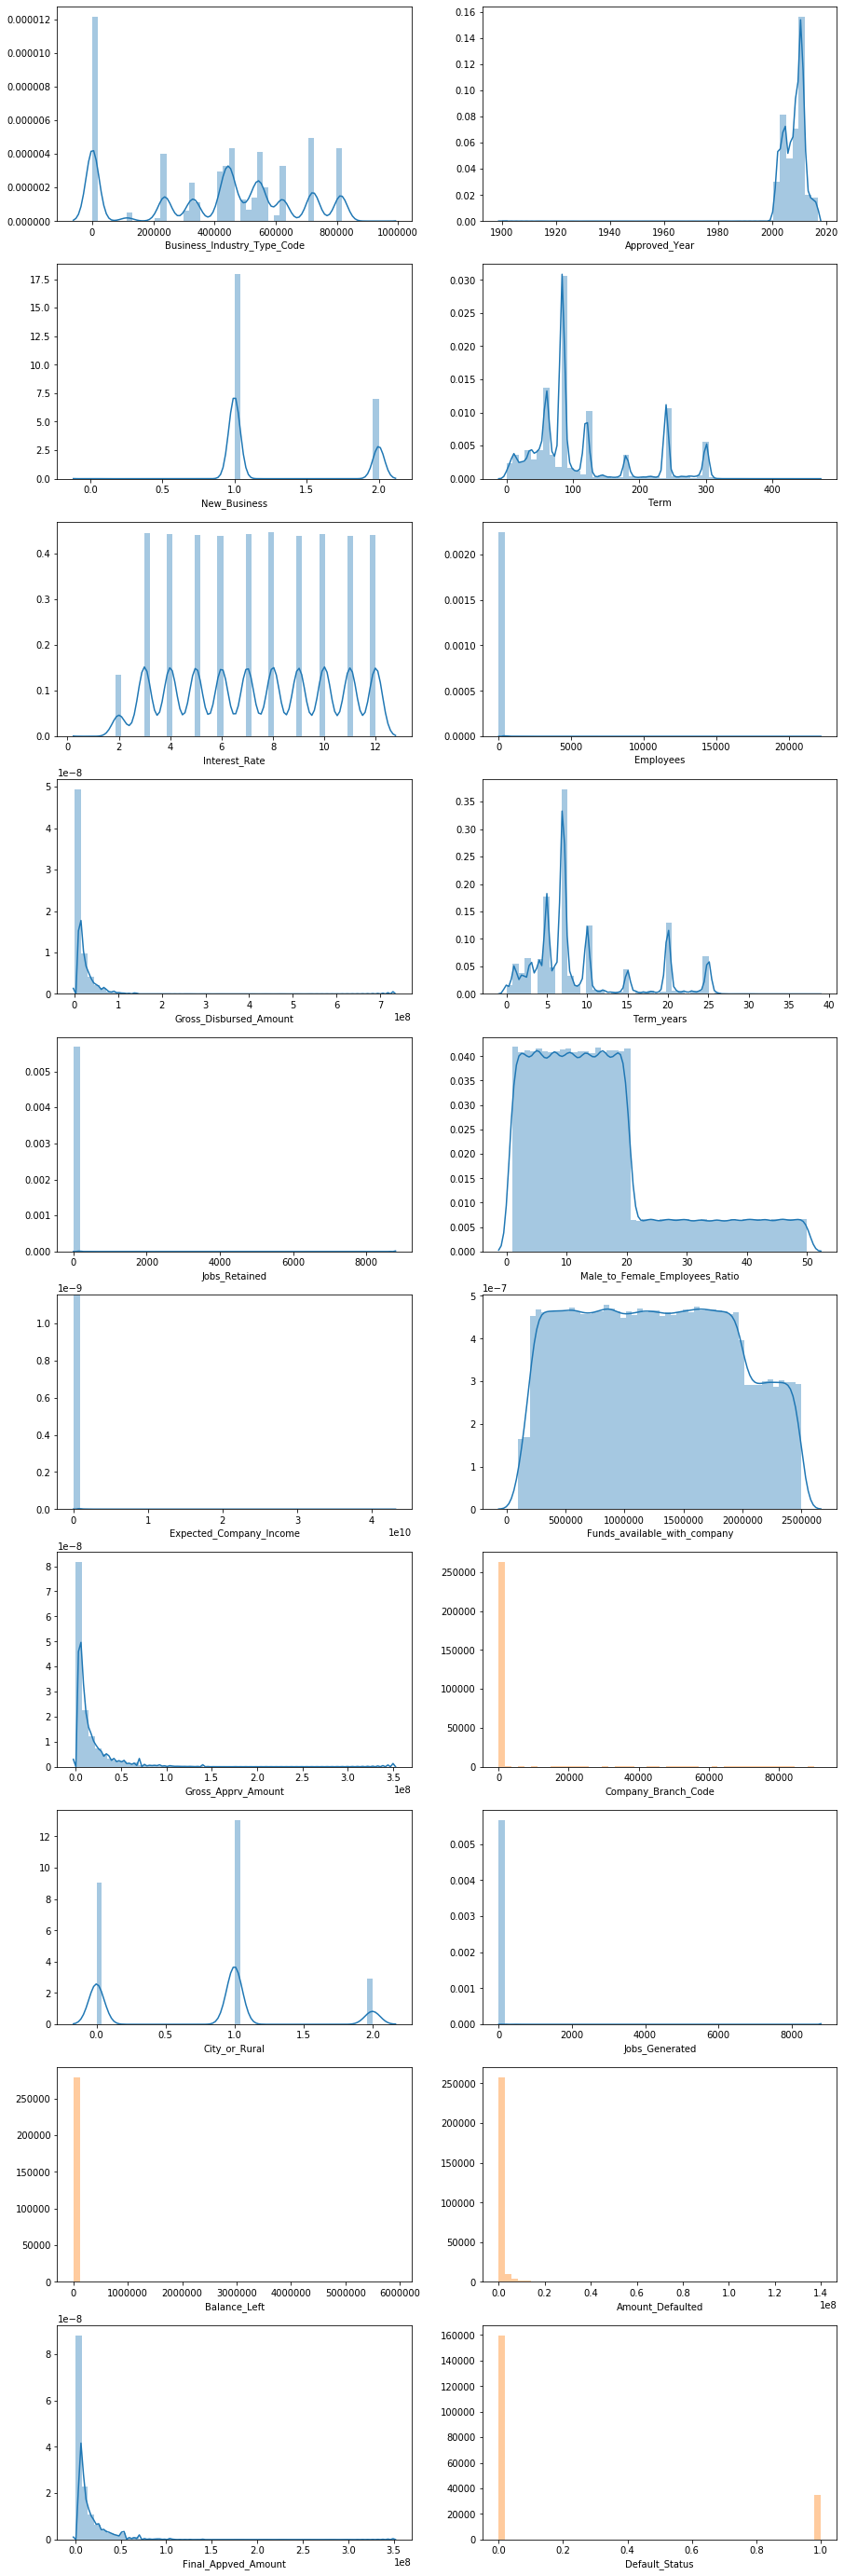

In [13]:
fig, axes = plt.subplots(figsize = (15, 50), nrows = int(df_num.shape[1]/2 + df_num.shape[1]/2 % 2), ncols = 2)

for i, col in enumerate(df_num.columns):
    try:
        sns.distplot(df_num[col], ax = axes[i//2, i%2])
    except:
        sns.distplot(df_num[col], kde = False, ax = axes[i//2, i%2])

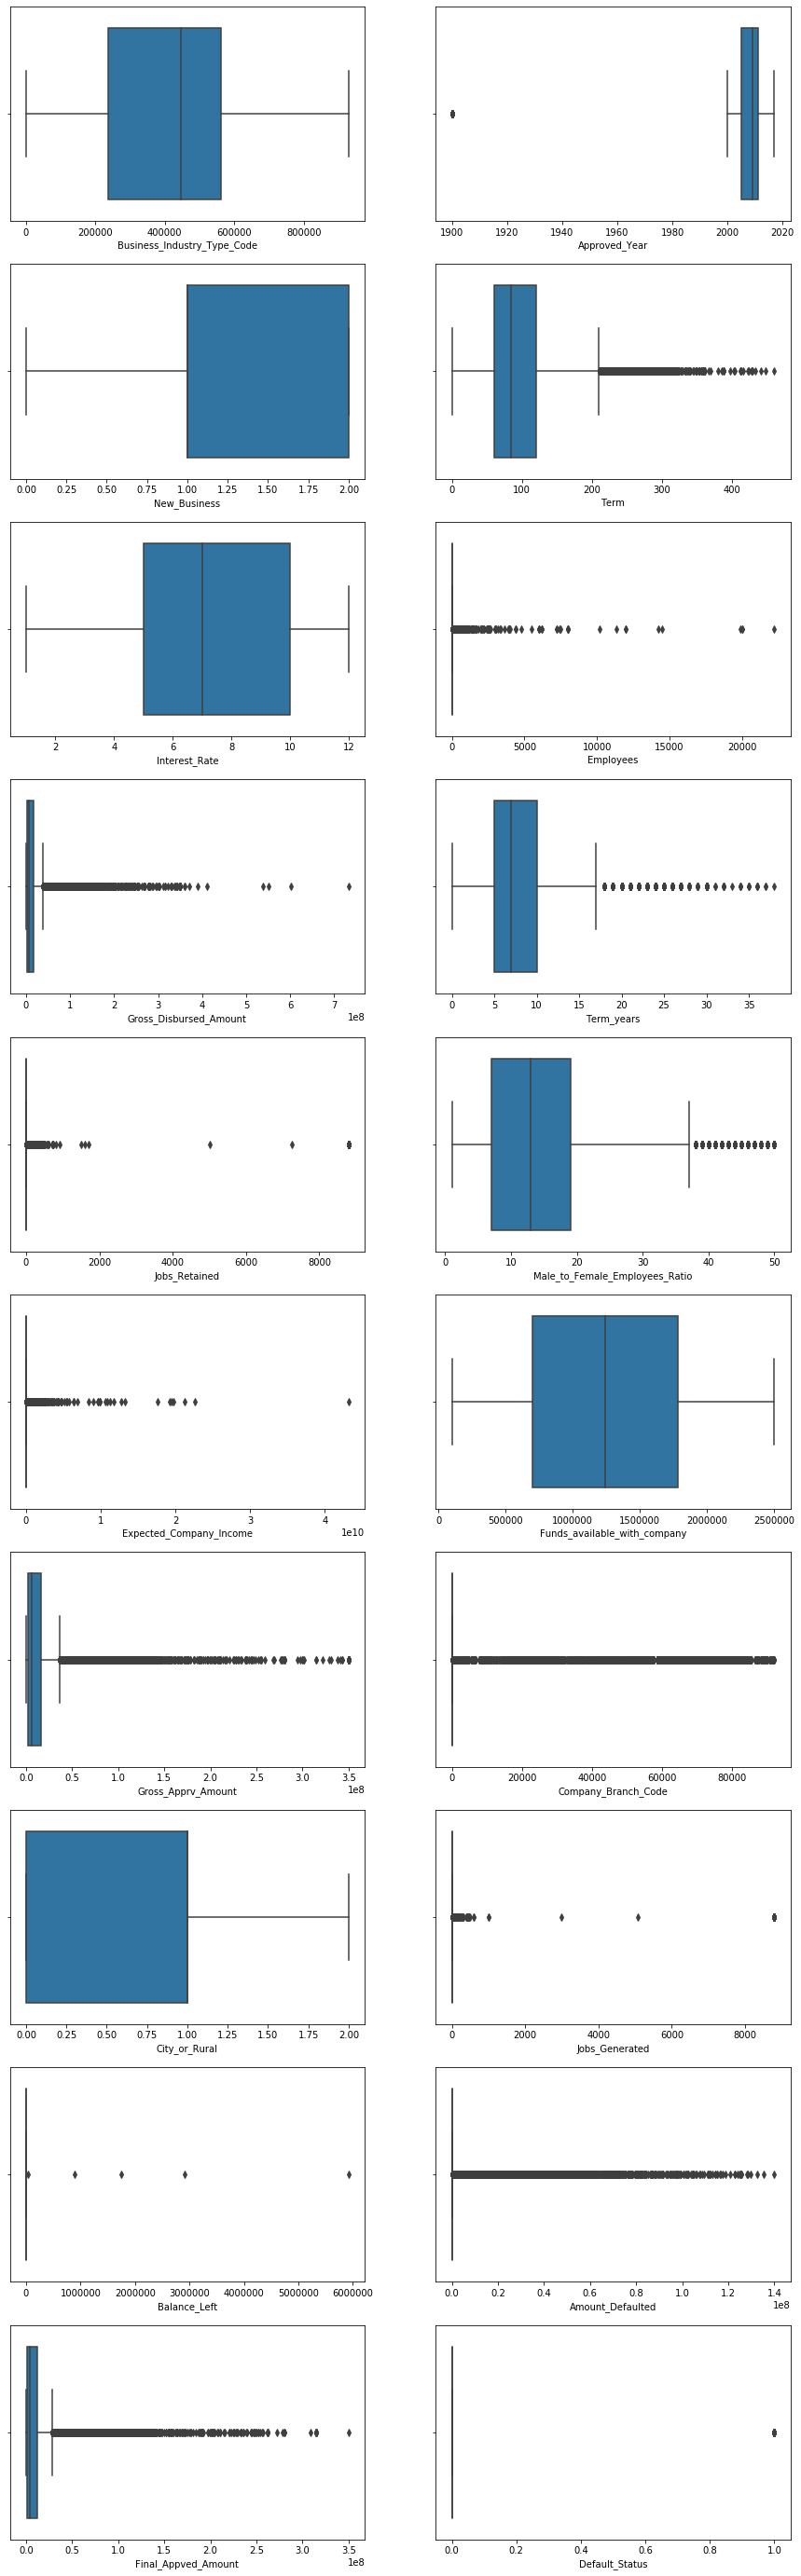

In [14]:
fig, axes = plt.subplots(figsize = (15, 50), nrows = int(df_num.shape[1]/2 + df_num.shape[1]/2 % 2), ncols = 2)

for i, col in enumerate(df_num.columns):
    sns.boxplot(df[col], ax = axes[i//2, i%2])

In [15]:
df.skew().sort_values(ascending = False)

Balance_Left                      385.858785
Expected_Company_Income           118.768216
Employees                         105.262395
Jobs_Generated                     36.493328
Jobs_Retained                      36.325819
Amount_Defaulted                   11.072940
Company_Branch_Code                 4.947932
Gross_Disbursed_Amount              4.011688
Final_Appved_Amount                 3.733018
Gross_Apprv_Amount                  3.586789
Default_Status                      1.660600
Male_to_Female_Employees_Ratio      1.214252
Term                                1.122079
Term_years                          1.120934
New_Business                        0.941596
City_or_Rural                       0.284892
Funds_available_with_company        0.094570
Interest_Rate                      -0.021006
Business_Industry_Type_Code        -0.259028
Approved_Year                     -11.263771
dtype: float64

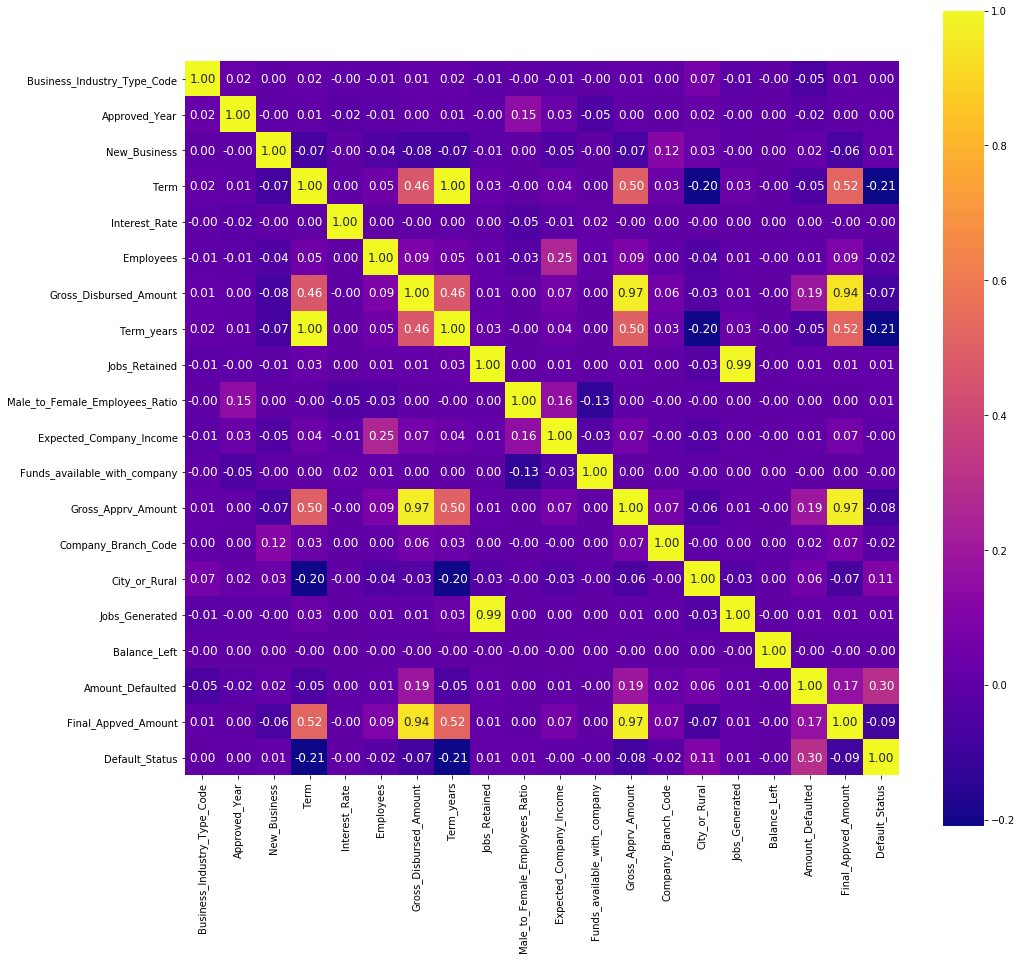

In [16]:
plt.figure(figsize = (16, 15))
sns.heatmap(df.corr(), square = True, annot = True, annot_kws = {'size': 12}, fmt = '.2f', cmap = 'plasma')

### Data Cleaning

In [17]:
df['Approved_Year'] = np.where(df['Approved_Year'] == 1900, 2000, df['Approved_Year'])

df['Carry-forward_Credit'].fillna(value = df['Carry-forward_Credit'].mode()[0], inplace = True)
df['Documents_Provided'].fillna(value = df['Documents_Provided'].mode()[0], inplace = True)
df['Bank_Masked'].fillna(value = df['Bank_Masked'].mode()[0], inplace = True)
df['Bank_Type'].fillna(value = df['Bank_Type'].mode()[0], inplace = True)
df['New_Business'].fillna(df['New_Business'].mode()[0], inplace = True)
df['New_Business'] = np.where(df['New_Business'] == 0, 2, df['New_Business'])

df.dropna(subset = ['Name_Masked', 'Business_Owner_State', 'Expected_Company_Income'], inplace = True)

### Feature Engineering

In [18]:
df[['Bank', 'IsBankNumber', 'Bank_Name/Number']] = df['Bank_Masked'].str.split('_', expand = True)
df.drop(['Bank', 'Bank_Masked'], axis = 1, inplace = True)
df['Bank_Name/Number'] = df['Bank_Name/Number'].astype('int64')

In [19]:
df[['Biz', 'Biz_Name', 'Biz_Number']] = df['Name_Masked'].str.split('_', expand = True)
df.drop(['Biz', 'Biz_Name', 'Name_Masked'], axis = 1, inplace = True)
df['Biz_Number'] = df['Biz_Number'].astype('int64')

In [20]:
df[df['BankState'].isna() == True]['Bank_Name/Number'].unique()

array([42, 37], dtype=int64)

In [21]:
df[df['Bank_Name/Number'] == 42].groupby('BankState')['Bank_Name/Number'].count().sort_values(ascending = False).head()

BankState
Maharashtra      10017
Delhi             2194
Haryana            768
Uttar Pradesh      233
Orissa               4
Name: Bank_Name/Number, dtype: int64

In [22]:
df[df['Bank_Name/Number'] == 37].groupby('BankState')['Bank_Name/Number'].count().sort_values(ascending = False).head()

BankState
Delhi            5047
Haryana           616
Maharashtra       603
Uttar Pradesh      70
Punjab             34
Name: Bank_Name/Number, dtype: int64

In [23]:
df['BankState'] = np.where((df['BankState'].isna() == True) & (df['Bank_Name/Number'] == 42), df['BankState'].fillna('Maharashtra', inplace = True), df['BankState']) 
df['BankState'] = np.where((df['BankState'].isna() == True) & (df['Bank_Name/Number'] == 37), df['BankState'].fillna('Delhi', inplace = True), df['BankState']) 

In [24]:
df['Male_Emp'] = df['Employees'] * df['Male_to_Female_Employees_Ratio']/(df['Male_to_Female_Employees_Ratio']+1)

In [25]:
df["Business_Ind_Type_Code_Freq"] = (df.groupby("Business_Industry_Type_Code")
                                     ["Business_Industry_Type_Code"].transform("count") 
                                     / df.Business_Industry_Type_Code.count())

In [26]:
df['Total_Funds_after_loan'] = df['Funds_available_with_company'] + df['Final_Appved_Amount']
df['Exp_Income_to_Total_Funds'] = df['Expected_Company_Income'] / df['Total_Funds_after_loan']

In [27]:
df['Appvd_ismonthend'] = df['Approved_Timestamp'].dt.floor('d') + pd.offsets.SemiMonthEnd()
df['Appvd_ismonthend'] = np.where(df['Appvd_ismonthend'].dt.day == 15, 0, 1)

df['Appvd_Qtr'] = df['Approved_Timestamp'].dt.quarter
df['Appvd_Month'] = df['Approved_Timestamp'].dt.month

df.drop('Approved_Timestamp', axis = 1, inplace = True)

df['Appvd_Qtr'].fillna(value = df['Appvd_Qtr'].mode()[0], inplace = True)
df['Appvd_Month'].fillna(value = df['Appvd_Month'].mode()[0], inplace = True)

In [28]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = df['Employees'].quantile(quantile_list)
df['Employees_Bracket'] = pd.qcut(df['Employees'], q = quantile_list)

In [29]:
abs(df.corr('kendall')['Default_Status']).sort_values(ascending = False)

Default_Status                    1.000000
Amount_Defaulted                  0.622199
Term_years                        0.234965
Term                              0.232206
Company_Branch_Code               0.140716
Final_Appved_Amount               0.112650
City_or_Rural                     0.110207
Total_Funds_after_loan            0.108814
Gross_Apprv_Amount                0.103473
Jobs_Retained                     0.093120
Gross_Disbursed_Amount            0.084294
Employees                         0.066293
Male_Emp                          0.063891
Expected_Company_Income           0.036372
Exp_Income_to_Total_Funds         0.035216
Jobs_Generated                    0.034625
New_Business                      0.009557
Approved_Year                     0.009103
Male_to_Female_Employees_Ratio    0.009002
Biz_Number                        0.007192
Bank_Name/Number                  0.003737
Business_Ind_Type_Code_Freq       0.002771
Balance_Left                      0.002658
Appvd_ismon

### Feature Transformation

In [30]:
df_num = df.select_dtypes(include = 'number')
df_cat = df.select_dtypes(exclude = 'number')

In [31]:
for col in df_cat.columns:
    df[col] = pd.Categorical(df[col]).codes

In [32]:
train_df = df[df['origin'] == 1].drop('origin', axis = 1)
test_df = df[df['origin'] == 0].drop('origin', axis = 1)

### Modeling

In [33]:
X = train_df.drop(['Default_Status', 'Balance_Left'], axis = 1)
y = train_df['Default_Status']

In [34]:
xgb_clf = XGBClassifier(
                    n_estimators = 167,
                    max_depth = 5, 
                    reg_alpha = 0.9,
                    colsample_bylevel = 0.65,
                    random_state = 98, 
                    n_jobs = -1
)

xgb_clf_cv = cross_val_score(xgb_clf,
                             X, y, groups = None, scoring = 'f1', 
                             cv = 5, n_jobs = -1, verbose = 0)


xgb_clf_cv.mean()

0.8057606890635437

In [35]:
xgb_clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.65,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=167, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=98, reg_alpha=0.9,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
pd.DataFrame(xgb_clf.feature_importances_, index = X.columns, columns = ['Feature Importance']).sort_values(ascending = False, by = ['Feature Importance'])

,Feature Importance
IsBankNumber,0.470559
Amount_Defaulted,0.351202
Term,0.031099
Expected_Company_Income,0.024260
Employees,0.016661
Biz_Number,0.016161
Exp_Income_to_Total_Funds,0.013030
Business_Industry_Type_Code,0.005894
Term_years,0.005769
Approved_Year,0.005056


### Test Predict and Submission

In [37]:
test_df.drop(['Default_Status', 'Balance_Left'], axis = 1, inplace = True)

In [38]:
test_pred = xgb_clf.predict(test_df)
sub = pd.DataFrame(test_pred, index = test_appID, columns = ['Default_Status'])
sub.to_csv('submission_ad.csv')

###### =========================== END =========================== 